In [61]:
import os
import config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
# 数据处理
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
# 模型训练
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#TODO
import xgboost as xgb
import lightgbm as lgb

# tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

np.random.seed(2021)
split_random_state = 7
split= 0.9

# 1.数据读取

In [ ]:
def load_numeric_training(standardize = True):
    """
    Load the pre-extracted features for the train data and 
    Returns: 
        a tuple of image ids, the data, and the labels, and classes
    """
    # read data
    train_path = os.path.join(config.data_dir, "train.csv")
    train = pd.read_csv(train_path)
    # encode train species strings
    le = LabelEncoder().fit(train.species)
    train_labels = le.transform(train.species)
    # save column names for submission
    classes = list(le.classes_)
    # save train and test ids
    train_ids = train.id
    # train and test predict features
    train = train.drop(["species", "id"], axis = 1)
    train = StandardScaler().fit_transfrom(train) if standardize else train
    return train, train_labels, train_ids, classes


def load_numeric_testing(standardize = True):
    """
    Load the pre-extracted features for the test data and
    Returns:
        a tuple of image ids, the data
    """
    # read data
    test_path = os.path.join(config.data_dir, "test.csv")
    test = pd.read_csv(test_path)
    # save ids
    test_ids = test.id
    # predict features
    test = test.drop(["id"], axis = 1)
    # standardize
    test = StandardScaler().fit_transform(test) if standardize else test
    return test, test_ids


def resize_img(img, max_dim = 96):
    """
    Resize the image to the maximum side is of size max_dim
    Returns:
        a new image of the right size
    """
    # load the axis with the larger dimension
    max_ax = max((0, 1), key = lambda i: img.size[i])
    # scale both axes so the image's largest dimenision is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))

    
def load_image_data(ids, max_dim=96, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

In [3]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [4]:
test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Columns: 193 entries, id to texture64
dtypes: float64(192), int64(1)
memory usage: 895.8 KB


In [7]:
train.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


In [8]:
test.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,...,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,780.673401,0.017562,0.028425,0.031858,0.022556,0.014527,0.037497,0.019222,0.001085,0.007092,...,0.035291,0.005923,0.015033,0.011762,0.015881,0.011217,0.002617,0.019975,0.009389,0.020970
std,465.646977,0.019585,0.038351,0.025719,0.028797,0.018029,0.051372,0.017122,0.002697,0.009515,...,0.064482,0.026934,0.022318,0.024771,0.014898,0.052530,0.011204,0.034704,0.013457,0.023407
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,368.500000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,774.000000,0.009766,0.010743,0.023438,0.013672,0.007812,0.013672,0.015625,0.000000,0.005859,...,0.003906,0.000000,0.005859,0.001953,0.012695,0.000000,0.000000,0.003418,0.002930,0.013184
75%,1184.500000,0.028809,0.041016,0.042969,0.027344,0.019531,0.056641,0.029297,0.000000,0.007812,...,0.038086,0.000000,0.019531,0.010498,0.022461,0.000000,0.000000,0.022461,0.014648,0.032227
max,1583.000000,0.085938,0.189450,0.167970,0.164060,0.093750,0.271480,0.087891,0.021484,0.083984,...,0.353520,0.441410,0.153320,0.177730,0.083984,0.606450,0.123050,0.247070,0.086914,0.149410


# 2.数据处理

In [9]:
# # v1
# def encode(train, test):
#     # encode train species strings
#     le = LabelEncoder().fit(train.species)
#     train_labels = le.transform(train.species)
#     # save column names for submission
#     classes = list(le.classes_)
#     # save train and test ids
#     train_ids = train.id
#     test_ids = test.id
#     # train and test predict features
#     train = train.drop(["species", "id"], axis = 1)
#     test = test.drop(["id"], axis = 1)
    
#     return train, train_labels, train_ids, test, test_ids, classes

# train, train_labels, train_ids, test, test_ids, classes = encode(train, test)

## 2.1 leaf classes

In [15]:
print(classes)
print()
print(len(classes))

['Acer_Capillipes', 'Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus', 'Acer_Palmatum', 'Acer_Pictum', 'Acer_Platanoids', 'Acer_Rubrum', 'Acer_Rufinerve', 'Acer_Saccharinum', 'Alnus_Cordata', 'Alnus_Maximowiczii', 'Alnus_Rubra', 'Alnus_Sieboldiana', 'Alnus_Viridis', 'Arundinaria_Simonii', 'Betula_Austrosinensis', 'Betula_Pendula', 'Callicarpa_Bodinieri', 'Castanea_Sativa', 'Celtis_Koraiensis', 'Cercis_Siliquastrum', 'Cornus_Chinensis', 'Cornus_Controversa', 'Cornus_Macrophylla', 'Cotinus_Coggygria', 'Crataegus_Monogyna', 'Cytisus_Battandieri', 'Eucalyptus_Glaucescens', 'Eucalyptus_Neglecta', 'Eucalyptus_Urnigera', 'Fagus_Sylvatica', 'Ginkgo_Biloba', 'Ilex_Aquifolium', 'Ilex_Cornuta', 'Liquidambar_Styraciflua', 'Liriodendron_Tulipifera', 'Lithocarpus_Cleistocarpus', 'Lithocarpus_Edulis', 'Magnolia_Heptapeta', 'Magnolia_Salicifolia', 'Morus_Nigra', 'Olea_Europaea', 'Phildelphus', 'Populus_Adenopoda', 'Populus_Grandidentata', 'Populus_Nigra', 'Prunus_Avium', 'Prunus_X_Shmittii', 'Pterocarya_S

## 2.2 train data

In [10]:
train.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [12]:
train_labels

array([ 3, 49, 65, 94, 84, 40, 54, 78, 53, 89, 98, 16, 74, 50, 58, 31, 43,
        4, 75, 44, 83, 84, 13, 66, 15,  6, 73, 22, 73, 31, 36, 27, 94, 88,
       12, 28, 21, 25, 20, 60, 84, 65, 69, 58, 23, 76, 18, 52, 54,  9, 48,
       47, 64, 81, 83, 36, 58, 21, 81, 20, 62, 88, 34, 92, 79, 82, 20, 32,
        4, 84, 36, 35, 72, 60, 71, 72, 52, 50, 54, 11, 51, 18, 47,  5,  8,
       37, 97, 20, 33,  1, 59,  1, 56,  1,  9, 57, 20, 79, 29, 16, 32, 54,
       93, 10, 46, 59, 84, 76, 15, 10, 15,  0, 69,  4, 51, 51, 94, 36, 39,
       62,  2, 24, 26, 35, 25, 87,  0, 55, 34, 38,  1, 45,  7, 93, 56, 38,
       21, 51, 75, 81, 74, 33, 20, 37,  9, 40, 60, 31, 83, 50, 71, 67, 30,
       66,  1, 43, 61, 23, 65, 84, 87, 46, 57, 16,  2, 28, 12, 96, 44, 76,
       29, 75, 41, 87, 67, 61, 30,  5, 12, 62,  3, 83, 81,  6, 85,  4, 37,
       57, 84, 39, 71, 61,  6, 76, 14, 31, 98, 40, 17, 51, 16, 42, 63, 86,
       37, 69, 86, 71, 80, 78, 14, 35, 25,  5, 39,  8,  9, 26, 44, 60, 13,
       14, 77, 13, 80, 87

In [18]:
train_ids

0         1
1         2
2         3
3         5
4         6
       ... 
985    1575
986    1578
987    1581
988    1582
989    1584
Name: id, Length: 990, dtype: int64

## 2.3 test data

In [16]:
test.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [17]:
test_ids

0         4
1         7
2         9
3        12
4        13
       ... 
589    1576
590    1577
591    1579
592    1580
593    1583
Name: id, Length: 594, dtype: int64

## 2.4 Stratified Split Train to train data and test data

In [27]:
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size = 0.8, random_state = 23)
for train_index, test_index in sss.split(train, train_labels):
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

In [32]:
print(X_train.shape)
print(y_train.shape)

(792, 192)
(792,)


In [34]:
print(X_test.shape)
print(y_test.shape)

(198, 192)
(198,)


### 3.模型训练

## 3.1 模型训练

In [40]:
# 分类器
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel = "rbf", C = 0.025, probability = True),
    NuSVC(probability = True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
]

# 模型训练
log_cols = ["Classifier", "Accuracy", "Log_Loss"]
log = pd.DataFrame(columns = log_cols)
for clf in classifiers:
    clf.fit(X_train, y_train)
    print("=" * 30)
    name = clf.__class__.__name__
    print(name)
    print("****Results****")
    # Accuray
    train_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, train_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    # Log loss
    train_pred = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_pred)
    print("Log Loss: {}".format(ll))
    
    # result save
    log_entry = pd.DataFrame([[name, acc * 100, ll]], columns = log_cols)
    log = log.append(log_entry)
print("=" * 30)

KNeighborsClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 1.5755075129933762
SVC
****Results****
Accuracy: 85.8586%
Log Loss: 4.62991773812156
NuSVC
****Results****
Accuracy: 92.9293%
Log Loss: 2.3855901489608926
DecisionTreeClassifier
****Results****
Accuracy: 64.1414%
Log Loss: 12.38511678807413
RandomForestClassifier
****Results****
Accuracy: 97.4747%
Log Loss: 0.7754750401027503
AdaBoostClassifier
****Results****
Accuracy: 4.5455%
Log Loss: 4.198743314459643
GradientBoostingClassifier
****Results****
Accuracy: 70.2020%
Log Loss: 2.1989969315801647
GaussianNB
****Results****
Accuracy: 57.0707%
Log Loss: 14.827252492813216
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.9798%
Log Loss: 0.22993448213653367
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 3.5354%
Log Loss: 33.31770854256545


## 3.2 模型结果查看

In [43]:
log

,Classifier,Accuracy,Log_Loss
0,KNeighborsClassifier,88.888889,1.575508
0,SVC,85.858586,4.629918
0,NuSVC,92.929293,2.385590
0,DecisionTreeClassifier,64.141414,12.385117
0,RandomForestClassifier,97.474747,0.775475
0,AdaBoostClassifier,4.545455,4.198743
0,GradientBoostingClassifier,70.202020,2.198997
0,GaussianNB,57.070707,14.827252
0,LinearDiscriminantAnalysis,97.979798,0.229934
0,QuadraticDiscriminantAnalysis,3.535354,33.317709


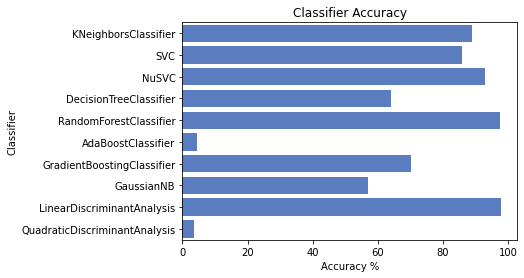

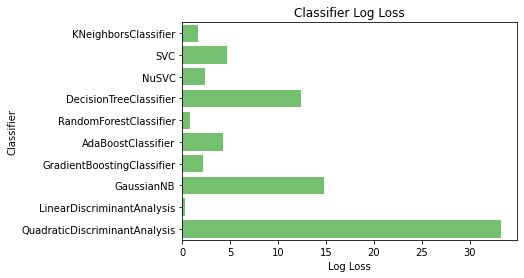

In [42]:
sns.set_color_codes("muted")
# plot accuracy
sns.barplot(x = "Accuracy", y = "Classifier", data = log, color = "b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()
# plot log loss
sns.barplot(x = "Log_Loss", y = "Classifier", data = log, color = "g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# 4.Submission

In [55]:
# predict test set
best_clf = LinearDiscriminantAnalysis()
best_clf.fit(train, train_labels)
test_pred = best_clf.predict_proba(test)
# format dataframe
submission = pd.DataFrame(test_pred, columns = classes)
submission.insert(0, "id", test_ids)
submission.reset_index()
submission.to_csv("./submission/submission.csv", index = False)
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,4.888114e-106,3.177641e-176,4.040550e-154,6.683534e-56,0.000000e+00,3.737644e-109,2.398363e-148,5.240645e-129,3.210441e-120,...,4.102716e-214,2.127184e-97,1.943917e-164,4.099180e-116,1.290950e-114,5.358103e-100,8.995206e-163,8.787448e-114,4.712085e-116,1.232607e-139
1,7,6.534663e-116,9.036490e-189,3.655757e-114,1.633693e-53,0.000000e+00,1.442295e-79,2.929777e-54,7.803869e-89,6.074046e-99,...,4.687433e-189,2.758545e-90,2.514327e-167,2.115711e-104,1.279534e-125,9.925805e-74,4.997854e-142,3.759199e-62,1.801477e-159,3.480013e-94
2,9,1.732574e-132,1.000000e+00,3.253842e-165,4.011473e-115,2.596026e-107,1.103025e-144,2.957515e-194,4.533194e-111,1.571194e-81,...,4.135724e-171,1.017036e-154,3.843398e-223,1.406767e-142,2.925518e-125,1.125774e-91,4.364809e-100,6.544629e-166,2.558139e-239,4.789803e-99
3,12,3.886277e-98,1.301959e-51,2.706416e-196,9.374950e-88,1.558349e-285,1.291822e-158,3.922758e-155,2.667139e-103,7.449604e-78,...,2.754660e-181,3.312733e-155,1.218356e-166,3.675450e-125,4.739345e-102,4.412553e-73,2.088992e-53,3.230801e-134,2.376264e-200,3.410910e-48
4,13,3.310915e-116,1.394666e-152,1.128612e-205,1.728891e-150,0.000000e+00,4.463769e-193,1.262326e-179,1.999040e-125,4.506214e-71,...,6.806761e-163,9.355956e-175,7.054331e-179,9.276957e-152,6.628431e-106,3.167089e-94,7.550116e-79,2.948533e-163,3.035137e-229,5.646266e-147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,3.819377e-147,1.000000e+00,7.398405e-184,1.664506e-141,9.023113e-147,7.716421e-189,1.944595e-234,4.945158e-138,5.116538e-107,...,6.171236e-211,1.379273e-182,1.265960e-234,1.278749e-152,1.135540e-156,2.704977e-114,9.691816e-104,1.717822e-197,9.780950e-267,1.082975e-126
590,1577,1.278227e-81,2.599623e-162,3.101128e-205,9.307525e-74,0.000000e+00,6.218490e-132,1.368553e-154,4.434254e-72,2.840461e-63,...,2.338263e-157,4.888144e-128,6.399639e-119,6.663441e-110,9.031130e-48,4.149560e-52,1.805851e-123,1.415372e-137,5.487143e-200,1.052720e-83
591,1579,1.018986e-80,7.262837e-158,2.347438e-125,4.444339e-50,0.000000e+00,8.131107e-88,6.981627e-144,3.409069e-101,1.255583e-106,...,5.367962e-195,3.205215e-108,3.568093e-132,2.314282e-92,1.351529e-91,1.413144e-85,1.109377e-155,5.363790e-81,3.319502e-137,7.853887e-89
592,1580,8.639969e-109,5.932993e-166,1.847783e-98,4.035072e-54,7.346742e-293,4.812781e-91,5.723581e-95,6.589808e-62,2.290126e-86,...,4.861330e-168,1.813748e-67,2.717546e-168,7.949215e-69,4.018930e-92,8.581546e-62,1.147375e-125,1.110713e-65,1.784030e-163,1.252021e-107
